Results:
- we subsetted Ag1000g P2 (1142 samples) zarr to the positions of the amplicon inserts

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import allel
import zarr
import sys
import os
allel.__version__, zarr.__version__

('1.2.1', '2.3.2')

In [2]:
PANEL = '../../data/panel_extended_info.csv'
# copy of whole dataset
LOCAL_DIR = '/Volumes/LaCie/ag1000g/phase2/AR1/'
VAR_ZARR = 'variation/main/zarr2-deprecated/ag1000g.phase2.ar1.pass.biallelic/'
SAMPLE_META = 'samples/samples.meta.txt'
# copy of subsetted dataset
SUBSET_DIR = '../../../data/phylo_ampl_ag1k/phase2/AR1'


## Panel

In [4]:
panel = pd.read_csv(PANEL)
panel.columns

Index(['Primary_ID', 'ID', 'SeekDeep_ID', 'SNP', 'F', 'R', 'chr', 'start',
       'end', 'F_deg', 'R_deg', 'identical_seq', 'idenified_lineages',
       'aligned_spp', 'unaligned_spp', 'aligned_ampl_length',
       'agam_ampl_length', 'aligned_insert_length', 'agam_insert_length',
       'total_snvs', 'total_indels', 'insert_snvs', 'insert_indels',
       'prop_id_lineages', 'exon', 'gene', 'intron', 'mRNA', 'repeat', 'utr',
       'AaegL5_identity', 'AaegL5_q_span', 'AaegL5_s_span', 'AgamP3_identity',
       'AgamP3_q_span', 'AgamP3_s_span', 'BDGP6_identity', 'BDGP6_q_span',
       'BDGP6_s_span', 'CpipJ2_identity', 'CpipJ2_q_span', 'CpipJ2_s_span',
       'Comments', 'Outgroup ampl', 'conc_multiplier', 'annotation',
       'start_insert', 'end_insert'],
      dtype='object')

In [5]:
# remove plasmodium primers from consideration
panel_mosquito = panel[~panel['Primary_ID'].str.startswith('P')]
print(panel.shape, panel_mosquito.shape)

(64, 48) (62, 48)


## Subset biallelic sites for amplicon positions

In [6]:
# read biallelic sites
callset = zarr.open(os.path.join(LOCAL_DIR, VAR_ZARR), mode='r')

In [7]:
def snp_select(chrom, start, stop, ampl):
    '''
    Collect position and SNP data for region
    '''
    
    
    #get genotypes
    g = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])

    #get positions
    p = allel.VariantChunkedTable(callset[chrom]['variants'],
                                     names=['POS'],
                                     index='POS')
    
    #get ref & alt
#     ref = callset[chrom]['variants/REF']
#     alt = callset[chrom]['variants/ALT']
    
    pos = p.POS[:]
    #just keep SNP positions within the region, exclude start - become 1-based
    gp = p.index.locate_range(start + 1, stop)
    gf = g[gp]
    ac = gf.count_alleles()
    # biallelic filter
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gn = gf.to_n_alt()
    
    # write all to zarr
    root = zarr.open_group(SUBSET_DIR, "a")
    g = root.create_group(ampl)
    g.create_dataset("POS", data=p[gp], dtype='i4')
    g.create_dataset("genotype", data=gf, dtype='i4')
    g.create_dataset("AC", data=ac, dtype='i4')
    g.create_dataset("biallelic", data=flt, dtype=bool)
    g.create_dataset("NALT", data=gn, dtype='i4')
#     g.create_dataset("REF", data=ref[gp], dtype='U1')

    return flt 
snp_select('2L',12345678, 12348678, 'test')

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True, False, False, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False, False, False,  True, False,  True, False,  True,
        True,  True,  True,  True,  True])

In [8]:
! ls {SUBSET_DIR}/test

AC        NALT      POS       biallelic genotype


In [9]:
# always pre-clean
! rm -rf {SUBSET_DIR}
# process all amplicoms
ampl_snps = dict()
for i, r in panel_mosquito.iterrows():
    sys.stdout.write('\r{}'.format(i))
    ampl_snps[r['Primary_ID']] = snp_select(r['chr'], r['start_insert'], r['end_insert'], r['Primary_ID'])
ampl_snps['1']

61

array([ True,  True,  True, False,  True,  True, False,  True,  True,
       False,  True, False,  True,  True, False,  True,  True])

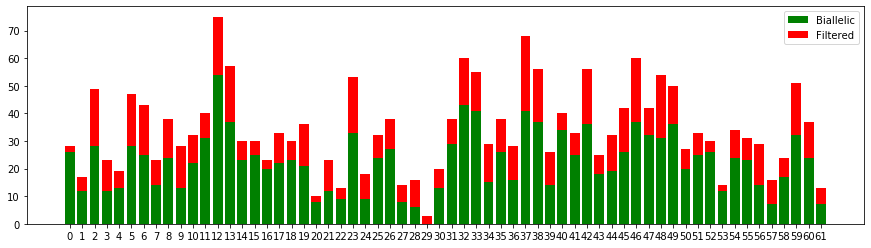

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
# how many variants in each amplicon?
for ampl in panel_mosquito.Primary_ID:
    nvar = ampl_snps[ampl][:]
    p1 = ax.bar(ampl, nvar.sum(), color='g')
    p2 = ax.bar(ampl, (nvar == False).sum(), bottom=nvar.sum(), color='r')
    plt.legend((p1[0], p2[0]), ('Biallelic', 'Filtered'))

In [11]:
# check zarr
! ls -la {SUBSET_DIR}/29/biallelic

total 16
drwxr-xr-x  4 am60  1567  128  5 Mar 17:28 .
drwxr-xr-x  8 am60  1567  256  5 Mar 17:28 ..
-rw-------  1 am60  1567  313  5 Mar 17:28 .zarray
-rw-------  1 am60  1567   19  5 Mar 17:28 0


## Copy metadata

In [12]:
! mkdir -p {os.path.dirname(os.path.join(SUBSET_DIR, SAMPLE_META))}
! cp {os.path.join(LOCAL_DIR, SAMPLE_META)} {os.path.join(SUBSET_DIR, SAMPLE_META)}